<a href="https://colab.research.google.com/github/sreeyadora/-Heart-_Attack_Prediction/blob/main/Heart__Attack_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import MDS, LocallyLinearEmbedding
import seaborn as sns # For better density plots if needed

In [3]:
dataset = pd.read_csv('dataset_1.csv')
dataset

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160,1.80,0.012,negative
1,21,1,94,98,46,296,6.75,1.060,positive
2,55,1,64,160,77,270,1.99,0.003,negative
3,64,1,70,120,55,270,13.87,0.122,positive
4,55,1,64,112,65,300,1.08,0.003,negative
...,...,...,...,...,...,...,...,...,...
94,75,1,60,138,58,116,2.85,0.023,positive
95,66,1,60,129,55,88,1.60,0.038,positive
96,40,1,60,97,44,167,6.91,0.051,positive
97,19,0,62,114,69,240,300.00,0.004,positive


In [4]:
from io import StringIO


In [5]:
# --- 1. Dataset Preprocessing ---
print("--- Original Dataset Info ---")
print(dataset.info())
print("\n--- Value Counts for Result ---")
print(dataset['Result'].value_counts())
print("\n--- Descriptive Stats (Before Cleaning) ---")
print(dataset.describe())

# Handle outlier in 'Heart rate'
# Find the outlier value
outlier_hr_value = 1111
if outlier_hr_value in dataset['Heart rate'].values:
    # Calculate median of heart rate, excluding the outlier for a more robust median
    median_hr = dataset[dataset['Heart rate'] != outlier_hr_value]['Heart rate'].median()
    dataset['Heart rate'] = dataset['Heart rate'].replace(outlier_hr_value, median_hr)
    print(f"\nReplaced Heart rate '{outlier_hr_value}' with median: {median_hr}")

# Encode target variable 'Result'
label_encoder = LabelEncoder()
dataset['Result_encoded'] = label_encoder.fit_transform(dataset['Result'])
# 'negative' will be 0, 'positive' will be 1 (usually alphabetical, check with classes_)
print(f"\nTarget classes mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

target_names = label_encoder.classes_ # ['negative', 'positive']
y = dataset['Result_encoded'].values

# Select features (all columns except 'Result' and 'Result_encoded')
X_df = dataset.drop(['Result', 'Result_encoded'], axis=1)
feature_names = X_df.columns.tolist()
X = X_df.values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n--- Processed Dataset Info ---")
print(f"Shape of X_scaled: {X_scaled.shape}")
print(f"Shape of y: {y.shape}")
print(f"Feature names: {feature_names}")

--- Original Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       99 non-null     int64  
 1   Gender                    99 non-null     int64  
 2   Heart rate                99 non-null     int64  
 3   Systolic blood pressure   99 non-null     int64  
 4   Diastolic blood pressure  99 non-null     int64  
 5   Blood sugar               99 non-null     int64  
 6   CK-MB                     99 non-null     float64
 7   Troponin                  99 non-null     float64
 8   Result                    99 non-null     object 
dtypes: float64(2), int64(6), object(1)
memory usage: 7.1+ KB
None

--- Value Counts for Result ---
Result
positive    57
negative    42
Name: count, dtype: int64

--- Descriptive Stats (Before Cleaning) ---
             Age     Gender   Heart rate  Systolic bloo

In [6]:
# --- 2. Model Implementation & Dimensionality Reduction to 2D (or 1D for LDA) ---
n_components_2d = 2

# a) PCA (Principal Component Analysis)
print("\nApplying PCA...")
pca = PCA(n_components=n_components_2d, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained variance ratio by 2 PCA components: {pca.explained_variance_ratio_}")
print(f"Total explained variance by PCA: {np.sum(pca.explained_variance_ratio_):.4f}")

# b) LDA (Linear Discriminant Analysis)
# For 2 classes, LDA can reduce to n_classes - 1 = 1 dimension.
print("\nApplying LDA...")
lda = LinearDiscriminantAnalysis(n_components=1) # Max 1 component for 2 classes
X_lda_1d = lda.fit_transform(X_scaled, y)
# For plotting on a 2D graph, we can add a dummy second dimension (e.g., zeros or small random noise)
# or plot as a 1D density/histogram. Here, we'll create a 1D scatter with jitter.
print(f"Explained variance ratio by 1 LDA component: {lda.explained_variance_ratio_}") # Should be 1.0 if only 1 component
print(f"Total explained variance by LDA: {np.sum(lda.explained_variance_ratio_):.4f}")

# c) MDS (Multidimensional Scaling)
print("\nApplying MDS...")
# Using fewer initializations for speed in this example; for best results, increase n_init.
mds = MDS(n_components=n_components_2d, random_state=42, normalized_stress='auto', n_init=2, max_iter=100)
X_mds = mds.fit_transform(X_scaled)
print(f"MDS stress: {mds.stress_:.4f}")

# d) LLE (Locally Linear Embedding)
print("\nApplying LLE...")
n_neighbors_lle = 15 # Should be > n_components. Typical values: 5-20
# Can sometimes fail if n_neighbors is too small or dataset structure is challenging.
try:
    lle = LocallyLinearEmbedding(n_components=n_components_2d, n_neighbors=n_neighbors_lle, random_state=42, method='standard')
    X_lle = lle.fit_transform(X_scaled)
    lle_error = lle.reconstruction_error_
    print(f"LLE reconstruction error: {lle_error:.4f}")
except Exception as e:
    print(f"LLE failed: {e}. Using PCA result for LLE plot placeholder.")
    X_lle = X_pca # Placeholder if LLE fails
    lle_error = np.nan


Applying PCA...
Explained variance ratio by 2 PCA components: [0.22363691 0.16625732]
Total explained variance by PCA: 0.3899

Applying LDA...
Explained variance ratio by 1 LDA component: [1.]
Total explained variance by LDA: 1.0000

Applying MDS...
MDS stress: 5298.5366

Applying LLE...
LLE reconstruction error: 0.0000


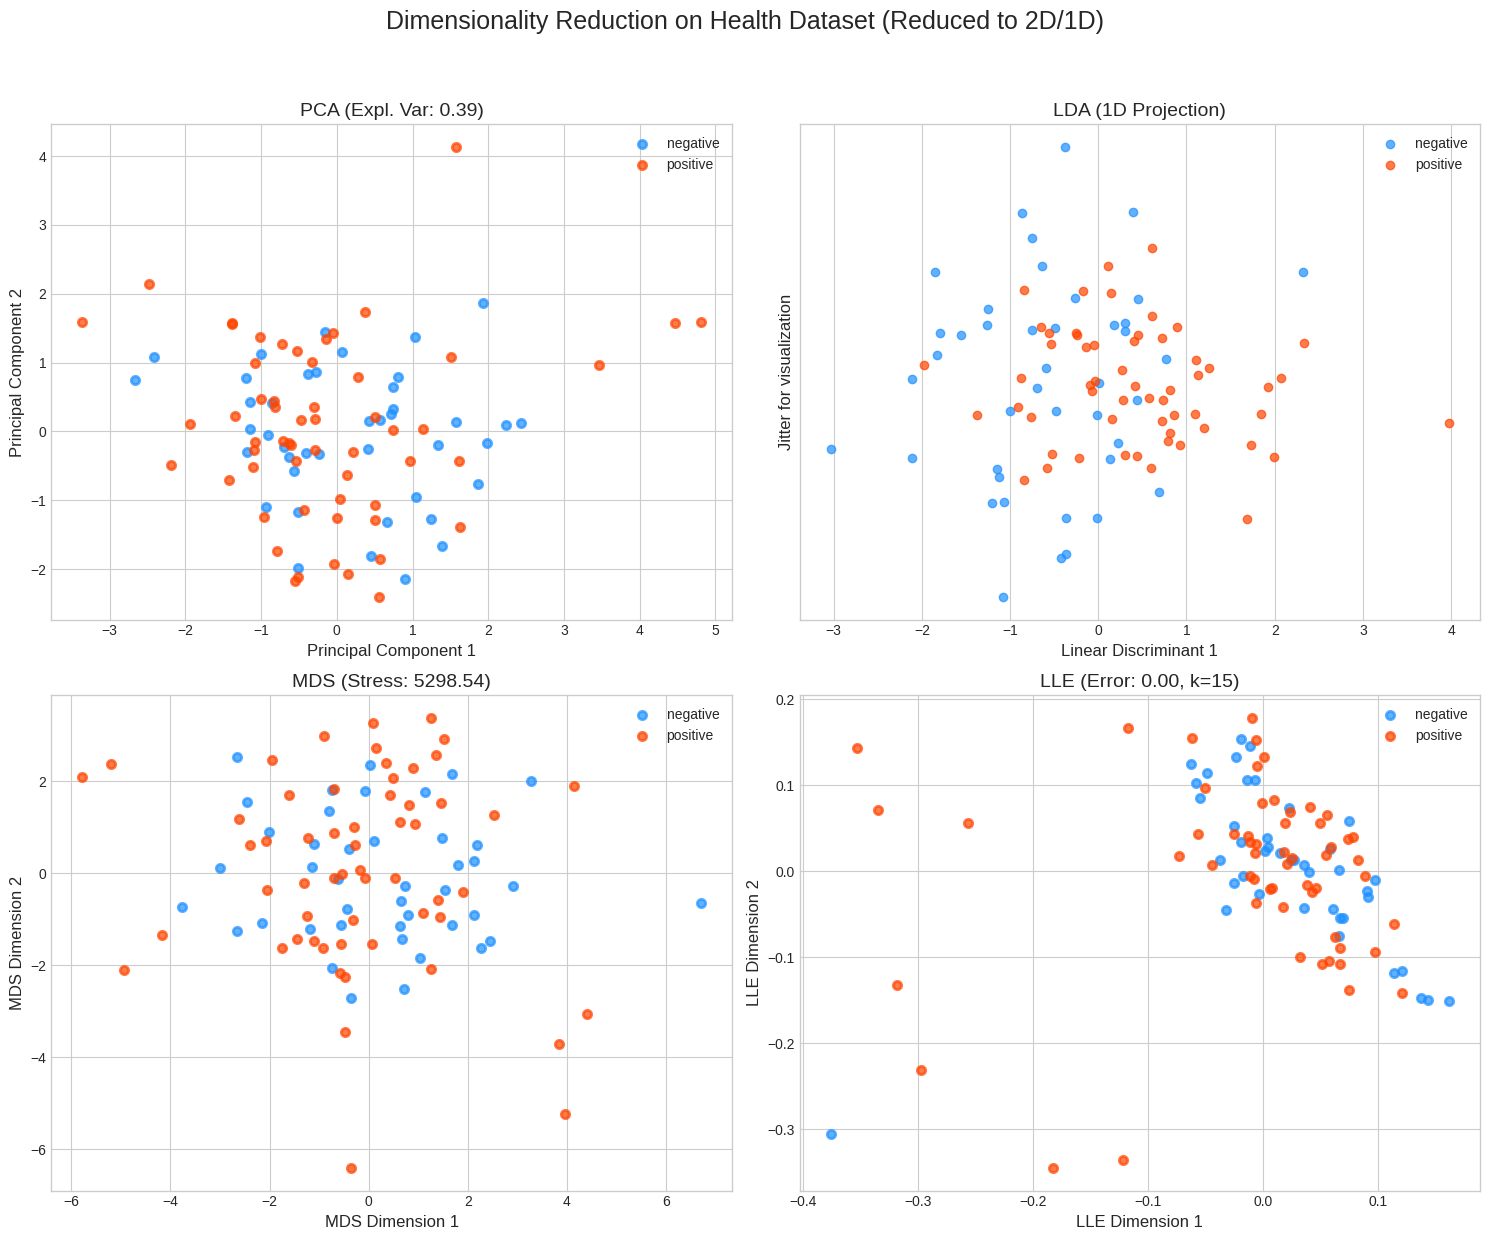

In [7]:

# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 13)) # Adjusted figsize
fig.suptitle('Dimensionality Reduction on Health Dataset (Reduced to 2D/1D)', fontsize=18)
colors_plot = ['dodgerblue', 'orangered'] # Negative, Positive
lw = 2

# PCA Plot
ax = axes[0, 0]
for color, i, target_name in zip(colors_plot, [0, 1], target_names):
    ax.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=.7, lw=lw,
                label=target_name)
ax.set_title(f'PCA (Expl. Var: {np.sum(pca.explained_variance_ratio_):.2f})', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.legend(loc='best', shadow=False, scatterpoints=1)

# LDA Plot (1D projection visualized)
ax = axes[0, 1]
# Add jitter for better visualization of 1D data
y_jitter = np.random.normal(0, 0.1, size=X_lda_1d.shape[0]) # Small random jitter for y-axis
for color, i, target_name in zip(colors_plot, [0, 1], target_names):
    ax.scatter(X_lda_1d[y == i, 0], y_jitter[y == i], alpha=.7, color=color,
                label=target_name)
ax.set_title(f'LDA (1D Projection)', fontsize=14) # Removed expl. var as it's 1 comp
ax.set_xlabel('Linear Discriminant 1', fontsize=12)
ax.set_yticks([]) # No meaningful y-axis
ax.set_ylabel('Jitter for visualization', fontsize=12)
ax.legend(loc='best', shadow=False, scatterpoints=1)
# Alternative LDA visualization (Density Plot)
# sns.kdeplot(data=pd.DataFrame({'LD1': X_lda_1d[:,0], 'Result': df['Result']}),
#             x='LD1', hue='Result', fill=True, ax=ax, palette=colors_plot)
# ax.set_title(f'LDA (1D Projection - Density)', fontsize=14)
# ax.set_xlabel('Linear Discriminant 1', fontsize=12)

# MDS Plot
ax = axes[1, 0]
for color, i, target_name in zip(colors_plot, [0, 1], target_names):
    ax.scatter(X_mds[y == i, 0], X_mds[y == i, 1], color=color, alpha=.7, lw=lw,
                label=target_name)
ax.set_title(f'MDS (Stress: {mds.stress_:.2f})', fontsize=14)
ax.set_xlabel('MDS Dimension 1', fontsize=12)
ax.set_ylabel('MDS Dimension 2', fontsize=12)
ax.legend(loc='best', shadow=False, scatterpoints=1)

# LLE Plot
ax = axes[1, 1]
if not np.isnan(lle_error):
    for color, i, target_name in zip(colors_plot, [0, 1], target_names):
        ax.scatter(X_lle[y == i, 0], X_lle[y == i, 1], color=color, alpha=.7, lw=lw,
                    label=target_name)
    ax.set_title(f'LLE (Error: {lle_error:.2f}, k={n_neighbors_lle})', fontsize=14)
else:
    ax.text(0.5, 0.5, 'LLE Failed', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='red')
    ax.set_title(f'LLE (Failed, k={n_neighbors_lle})', fontsize=14)

ax.set_xlabel('LLE Dimension 1', fontsize=12)
ax.set_ylabel('LLE Dimension 2', fontsize=12)
ax.legend(loc='best', shadow=False, scatterpoints=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle and axes labels
plt.show()

In [8]:
# --- For Report: Output snippet ---
print("\n--- PCA Reduced Data (First 5 samples) ---")
print(pd.DataFrame(X_pca, columns=['PC1', 'PC2']).head())

print("\n--- LDA Reduced Data (First 5 samples, 1D) ---")
print(pd.DataFrame(X_lda_1d, columns=['LD1']).head())

print("\n--- MDS Reduced Data (First 5 samples) ---")
print(pd.DataFrame(X_mds, columns=['MDS1', 'MDS2']).head())

if not np.isnan(lle_error):
    print("\n--- LLE Reduced Data (First 5 samples) ---")
    print(pd.DataFrame(X_lle, columns=['LLE1', 'LLE2']).head())
else:
    print("\n--- LLE Failed ---")


--- PCA Reduced Data (First 5 samples) ---
        PC1       PC2
0  1.580008  0.137439
1 -3.362731  1.588603
2  0.747643  0.325789
3 -1.099073 -0.264310
4 -1.148762  0.029295

--- LDA Reduced Data (First 5 samples, 1D) ---
        LD1
0 -0.747862
1 -0.839300
2 -1.551069
3  0.401143
4 -0.013554

--- MDS Reduced Data (First 5 samples) ---
       MDS1      MDS2
0  1.681616 -1.119283
1 -4.168529 -1.345395
2  1.045556 -1.848541
3 -1.602295  1.704830
4 -2.006772  0.889727

--- LLE Reduced Data (First 5 samples) ---
       LLE1      LLE2
0  0.120595 -0.115684
1 -0.117592  0.166892
2  0.065831 -0.074947
3 -0.006559 -0.037055
4 -0.025139 -0.013768
